# Projeto de Reconhecimento de Dígitos


## 1. Importando e processando os dados:

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
train = pd.read_csv("train.csv", sep=";")
test = pd.read_csv("test.csv", sep=";")

print("Formato do train.csv:", train.shape)
print("Formato do test.csv:", test.shape)

train.head()

Formato do train.csv: (2186, 785)
Formato do test.csv: (1115, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def calcular_intensidade(imagem):
    return np.sum(imagem) / 255

def calcular_simetria(imagem):
    matriz = imagem.reshape(28, 28)

    sim_v = np.sum(np.abs(matriz[:, :14] - np.fliplr(matriz[:, 14:])))

    sim_h = np.sum(np.abs(matriz[:14, :] - np.flipud(matriz[14:, :])))

    sim_total = (sim_v + sim_h) / 255
    return sim_total

In [ ]:
dados_train = []
for _, linha in tqdm(train.iterrows(), total=len(train)):
    label = linha["label"]
    imagem = linha.drop("label").values.astype(np.float32)

    intensidade = calcular_intensidade(imagem)
    simetria = calcular_simetria(imagem)

    dados_train.append([label, intensidade, simetria])

train_redu = pd.DataFrame(dados_train, columns=["label", "intensidade", "simetria"])
train_redu.to_csv("train_redu.csv", index=False)

print("Novo train_redu.csv criado com formato:", train_redu.shape)
train_redu.head()

100%|██████████| 2186/2186 [00:00<00:00, 2254.46it/s]

Novo train_redu.csv criado com formato: (2186, 3)


,label,intensidade,simetria
0,0,145.435287,148.572556
1,0,118.576469,137.113724
2,0,127.599998,134.047058
3,0,138.047058,151.003922
4,0,146.215683,122.501961


In [ ]:
dados_test = []
for _, linha in tqdm(test.iterrows(), total=len(test)):
    label = linha["label"]
    imagem = linha.drop("label").values.astype(np.float32)

    intensidade = calcular_intensidade(imagem)
    simetria = calcular_simetria(imagem)

    dados_test.append([label, intensidade, simetria])

test_redu = pd.DataFrame(dados_test, columns=["label", "intensidade", "simetria"])
test_redu.to_csv("test_redu.csv", index=False)

print("Novo test_redu.csv criado com formato:", test_redu.shape)
test_redu.head()

100%|██████████| 1115/1115 [00:00<00:00, 2168.37it/s]

Novo test_redu.csv criado com formato: (1115, 3)


,label,intensidade,simetria
0,0,147.933334,130.470581
1,0,131.054901,122.721565
2,0,134.890198,151.725494
3,0,139.976471,133.921570
4,0,129.580399,130.274506


## 2. Filtrando dígitos 1 e 5 e treinando modelos:

In [ ]:
train1x5 = train_redu[train_redu["label"].isin([1, 5])].copy()
test1x5  = test_redu[test_redu["label"].isin([1, 5])].copy()

train1x5["y"] = train1x5["label"].apply(lambda x: 1 if x == 1 else -1)
test1x5["y"]  = test1x5["label"].apply(lambda x: 1 if x == 1 else -1)

X_1x5 = train1x5[["intensidade", "simetria"]].values.astype(float)
y = train1x5["y"].values.astype(int)

X_train_1x5, X_val_1x5, y_train, y_val = train_test_split(
    X_1x5, y, test_size=0.2, random_state=42, stratify=y
)

X_test_1x5 = test1x5[['intensidade','simetria']].values.astype(float)
y_test = test1x5['y'].values.astype(int)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_1x5)
X_val   = scaler.transform(X_val_1x5)
X_test  = scaler.transform(X_test_1x5)

print(X_train)
print(X_test)

[[0.18135993 0.34171756]
 [0.22420632 0.25950261]
 [0.20833334 0.09019244]
 ...
 [0.11861864 0.1770061 ]
 [0.02933287 0.21351478]
 [0.08939296 0.2763961 ]]
[[0.104837   0.16236513]
 [0.10531962 0.32519947]
 [0.01195836 0.17709995]
 ...
 [0.69969968 0.77006103]
 [0.86025315 0.83923048]
 [1.00734662 0.78385743]]


In [ ]:
print("Tamanho treino:", X_train.shape)
print("Tamanho validação:", X_val.shape)
print("Tamanho teste:", X_test.shape)

Tamanho treino: (947, 2)
Tamanho validação: (237, 2)
Tamanho teste: (583, 2)


### 2.1 Predição utilizando Perceptron, Regressão Linear e Regressão Logística:

In [ ]:
class PerceptronPLA:
    def __init__(self, max_iter=10000):
        self.w = None
        self.max_iter = max_iter

    def constroiListaPCI(self, X, y, w):
        l = []
        new_y = []
        for i in range(len(X)):
            pred = np.sign(np.dot(X[i], w))
            if pred != y[i]:
                l.append(X[i])
                new_y.append(y[i])
        return l, new_y

    def fit(self, X, y):
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

        n_samples, n_features = X_bias.shape
        self.w = np.zeros(n_features, dtype=float)

        iteracao = 0
        l, new_y = self.constroiListaPCI(X_bias, y, self.w)

        melhor_w = self.w.copy()
        menor_erro = len(l)

        while len(l) > 0 and iteracao < self.max_iter:
            idx = np.random.randint(len(l))
            x_i = l[idx]
            y_i = new_y[idx]

            self.w += y_i * x_i

            l, new_y = self.constroiListaPCI(X_bias, y, self.w)
            erros = len(l)

            if erros < menor_erro:
                melhor_w = self.w.copy()
                menor_erro = erros

            iteracao += 1

        self.w = melhor_w

        if iteracao == self.max_iter:
            print(f"Atenção: número máximo de iterações ({self.max_iter}) atingido. Melhor solução tem {menor_erro} erros.")

    def predict(self, X):
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        return np.sign(X_bias @ self.w)

In [ ]:
perceptron = PerceptronPLA()
perceptron.fit(X_train, y_train)

print(perceptron.w)
print(perceptron.predict(X_test))

[ 1.         -1.08687262 -0.72670103]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. 

In [ ]:
class RegressaoLinear:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape

        X = np.hstack([X, np.ones((n_samples, 1))])

        self.w = np.linalg.pinv(X.T @ X) @ (X.T @ y)

    def predict(self, X, class_output=True):
        X_bias = np.c_[X, np.ones(X.shape[0])]

        y_pred = X_bias @ self.w

        if class_output:
            y_class = np.sign(y_pred)
            y_class[y_class == 0] = 1
            return y_class

        return y_pred

In [ ]:
linreg = RegressaoLinear()
linreg.fit(X_train, y_train)

print(linreg.w)
print(linreg.predict(X_test))
print(linreg.predict(X_test, class_output=False))

[-1.39341775 -1.7739818   1.56309115]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. 

In [ ]:
class RegressaoLogistica:
    def __init__(self, eta=0.01, tmax=5000, lambda_=0.01):
        self.eta = eta
        self.tmax = tmax
        self.lambda_ = lambda_
        self.w = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        X = np.c_[np.ones((X.shape[0], 1)), X]

        n_amostras, n_features = X.shape
        self.w = np.zeros(n_features)

        for _ in range(self.tmax):
            z = X @ self.w

            grad = -(1/n_amostras) * (X.T @ (y / (1 + np.exp(y * z))))

            grad[1:] += self.lambda_ * self.w[1:]

            self.w -= self.eta * grad

    def predict_prob(self, X):
        X = np.array(X)
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return self.sigmoid(X @ self.w)

    def predict(self, X):
        X = np.array(X)
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return np.sign(X @ self.w)

    def getRegressionY(self, regressionX, shift=0):
        return (-self.w[0] + shift - self.w[1]*regressionX) / self.w[2]

In [ ]:
logreg = RegressaoLogistica()
logreg.fit(X_train, y_train)

print(logreg.w)
print(logreg.predict(X_test))

[ 2.2402976  -2.37574318 -2.43081271]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. 

### 2.2 Avaliando modelos de predição:

In [ ]:
def avaliar_modelo(nome, modelo, X_val, y_val, X_te, y_te):
    yv = modelo.predict(X_val)
    yt = modelo.predict(X_te)

    print(f"\n=== {nome} | Validação ===")
    print(confusion_matrix(y_val, yv, labels=[-1, 1]))
    print(classification_report(y_val, yv, labels=[-1, 1], target_names=["Dígito 5 (-1)", "Dígito 1 (+1)"]))
    print("Acurácia (val): {:.2f}%".format(100*accuracy_score(y_val, yv)))

    print(f"\n=== {nome} | Teste ===")
    print(confusion_matrix(y_te, yt, labels=[-1, 1]))
    print(classification_report(y_te, yt, labels=[-1, 1],target_names=["Dígito 5 (-1)", "Dígito 1 (+1)"]))
    print("Acurácia (test): {:.2f}%".format(100*accuracy_score(y_te, yt)))

In [ ]:
avaliar_modelo("Perceptron", perceptron, X_val, y_val, X_test, y_test)


=== Perceptron | Validação ===
[[115   0]
 [  0 122]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       115
Dígito 1 (+1)       1.00      1.00      1.00       122

     accuracy                           1.00       237
    macro avg       1.00      1.00      1.00       237
 weighted avg       1.00      1.00      1.00       237

Acurácia (val): 100.00%

=== Perceptron | Teste ===
[[291   0]
 [  0 292]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       291
Dígito 1 (+1)       1.00      1.00      1.00       292

     accuracy                           1.00       583
    macro avg       1.00      1.00      1.00       583
 weighted avg       1.00      1.00      1.00       583

Acurácia (test): 100.00%


In [ ]:
avaliar_modelo("Regressão Linear", linreg, X_val, y_val, X_test, y_test)


=== Regressão Linear | Validação ===
[[115   0]
 [  0 122]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       115
Dígito 1 (+1)       1.00      1.00      1.00       122

     accuracy                           1.00       237
    macro avg       1.00      1.00      1.00       237
 weighted avg       1.00      1.00      1.00       237

Acurácia (val): 100.00%

=== Regressão Linear | Teste ===
[[291   0]
 [  0 292]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       291
Dígito 1 (+1)       1.00      1.00      1.00       292

     accuracy                           1.00       583
    macro avg       1.00      1.00      1.00       583
 weighted avg       1.00      1.00      1.00       583

Acurácia (test): 100.00%


In [ ]:
avaliar_modelo("Regressão Logística", logreg, X_val, y_val, X_test, y_test)


=== Regressão Logística | Validação ===
[[115   0]
 [  0 122]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       115
Dígito 1 (+1)       1.00      1.00      1.00       122

     accuracy                           1.00       237
    macro avg       1.00      1.00      1.00       237
 weighted avg       1.00      1.00      1.00       237

Acurácia (val): 100.00%

=== Regressão Logística | Teste ===
[[291   0]
 [  0 292]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       291
Dígito 1 (+1)       1.00      1.00      1.00       292

     accuracy                           1.00       583
    macro avg       1.00      1.00      1.00       583
 weighted avg       1.00      1.00      1.00       583

Acurácia (test): 100.00%


### 2.3 Plotando retas formadas pelos modelos preditivos:

In [ ]:
def plot_points(X, y_true, y_preds, label_prefix=""):
    colors = ['blue', 'red']
    markers = ['o', 'x']

    y_pred = y_preds[0]

    plt.scatter(X[(y_true==1)&(y_pred==1),0], X[(y_true==1)&(y_pred==1),1], color=colors[0], label=f'{label_prefix} 1 correto', edgecolor='k', s=60)
    plt.scatter(X[(y_true==-1)&(y_pred==-1),0], X[(y_true==-1)&(y_pred==-1),1], color=colors[1], label=f'{label_prefix} 5 correto', edgecolor='k', s=60)

    plt.scatter(X[(y_true==1)&(y_pred==-1),0], X[(y_true==1)&(y_pred==-1),1], color=colors[0], marker='x', s=80, label=f'{label_prefix} 1 incorreto')
    plt.scatter(X[(y_true==-1)&(y_pred==1),0], X[(y_true==-1)&(y_pred==1),1],color=colors[1], marker='x', s=80, label=f'{label_prefix} 5 incorreto')

def calcula_y_model(model, x_vals, titulo):
    if titulo.lower().startswith("regressão linear"):

        return -(model.w[0]*x_vals + model.w[2]) / model.w[1]
    else:

        return -(model.w[0] + model.w[1]*x_vals) / model.w[2]

In [ ]:
def plot_model_results_normalized(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler, titulo="Modelo"):
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    x_vals = np.linspace(-0.25, 1.25, 300)

    plt.figure(figsize=(8,6))
    plt.scatter(X_train_scaled[y_train==1,0],  X_train_scaled[y_train==1,1],  label='Treino: 1 (+1)',  alpha=0.7)
    plt.scatter(X_train_scaled[y_train==-1,0], X_train_scaled[y_train==-1,1], label='Treino: 5 (-1)', alpha=0.7)
    plt.scatter(X_val_scaled[y_val==1,0],      X_val_scaled[y_val==1,1],      marker='x', label='Val: 1 (+1)')
    plt.scatter(X_val_scaled[y_val==-1,0],     X_val_scaled[y_val==-1,1],     marker='x', label='Val: 5 (-1)')

    if (titulo.lower().startswith("regressão linear") and not np.isclose(model.w[1], 0.0)) or \
       (not titulo.lower().startswith("regressão linear") and not np.isclose(model.w[2], 0.0)):
        y_vals = calcula_y_model(model, x_vals, titulo)
        plt.plot(x_vals, y_vals, 'k-', linewidth=2, label=f'Fronteira {titulo}')
    else:
        if titulo.lower().startswith("regressão linear"):
            x_vert = -model.w[2] / model.w[0]
        else:
            x_vert = -model.w[0] / model.w[1]
        plt.axvline(x_vert, linewidth=2, color='k', label=f'Fronteira {titulo}')

    plt.xlabel("Intensidade (normalizada)")
    plt.ylabel("Simetria (normalizada)")
    plt.title(f"{titulo} - Treino + Validação (normalizado)")
    plt.legend()
    plt.grid(True)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.show()

    plt.figure(figsize=(8,6))

    if titulo.lower().startswith("regressão linear"):
        yt = model.predict(X_test_scaled, class_output=True)
    else:
        yt = model.predict(X_test_scaled)

    plt.scatter(X_test_scaled[(y_test==1)&(yt==1),0],   X_test_scaled[(y_test==1)&(yt==1),1],   label='Teste: 1 correto', alpha=0.8)
    plt.scatter(X_test_scaled[(y_test==-1)&(yt==-1),0], X_test_scaled[(y_test==-1)&(yt==-1),1], label='Teste: 5 correto', alpha=0.8)
    plt.scatter(X_test_scaled[(y_test==1)&(yt==-1),0],  X_test_scaled[(y_test==1)&(yt==-1),1],  marker='x', s=80, label='Teste: 1 incorreto')
    plt.scatter(X_test_scaled[(y_test==-1)&(yt==1),0],  X_test_scaled[(y_test==-1)&(yt==1),1],  marker='x', s=80, label='Teste: 5 incorreto')

    if (titulo.lower().startswith("regressão linear") and not np.isclose(model.w[1], 0.0)) or \
       (not titulo.lower().startswith("regressão linear") and not np.isclose(model.w[2], 0.0)):
        y_vals = calcula_y_model(model, x_vals, titulo)
        plt.plot(x_vals, y_vals, 'k-', linewidth=2, label=f'Fronteira {titulo}')
    else:
        if titulo.lower().startswith("regressão linear"):
            x_vert = -model.w[2] / model.w[0]
        else:
            x_vert = -model.w[0] / model.w[1]
        plt.axvline(x_vert, linewidth=2, color='k', label=f'Fronteira {titulo}')

    plt.xlabel("Intensidade (normalizada)")
    plt.ylabel("Simetria (normalizada)")
    plt.title(f"{titulo} - Teste (normalizado)")
    plt.legend()
    plt.grid(True)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.show()

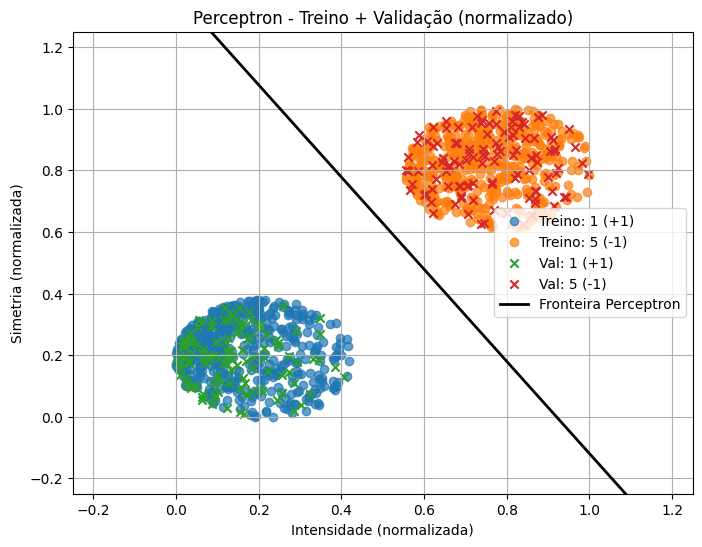

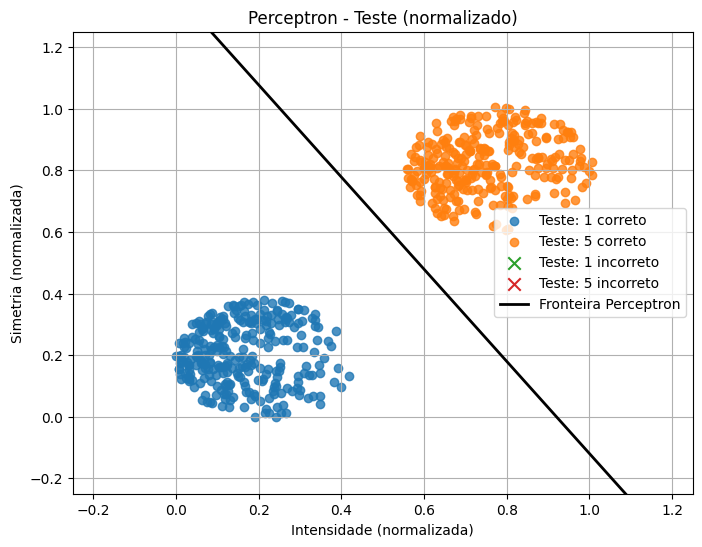

In [ ]:
plot_model_results_normalized(perceptron, X_train_1x5, y_train, X_val_1x5, y_val, X_test_1x5, y_test, scaler, "Perceptron")

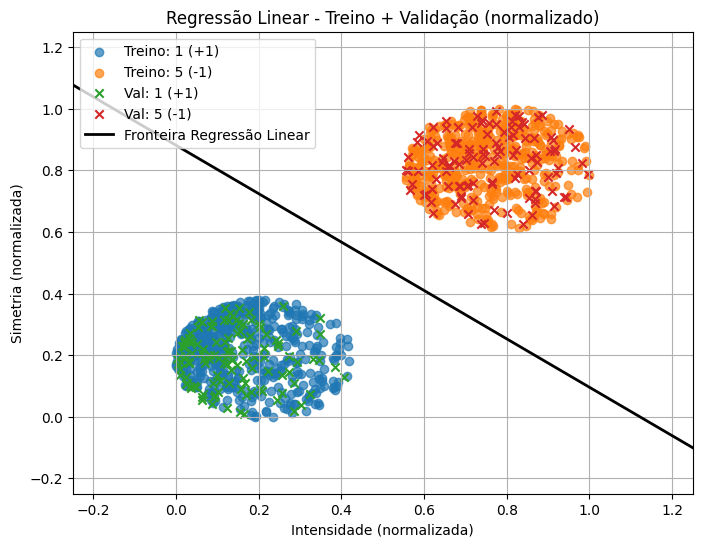

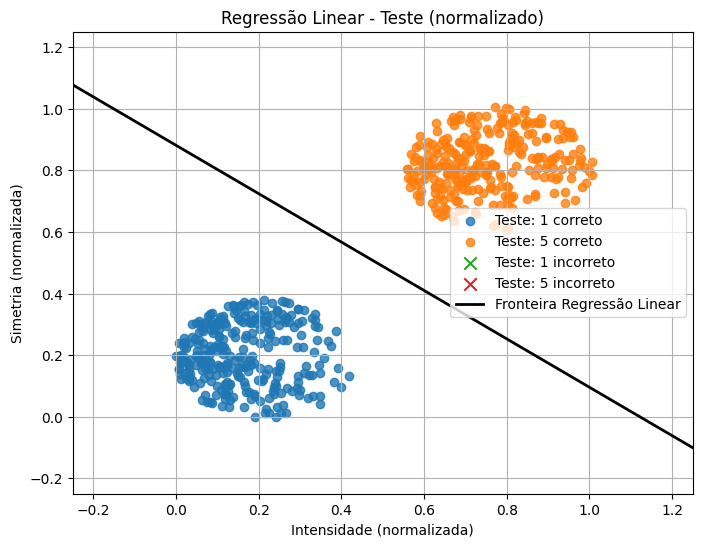

In [ ]:
plot_model_results_normalized(linreg, X_train_1x5, y_train, X_val_1x5, y_val, X_test_1x5, y_test, scaler, "Regressão Linear")

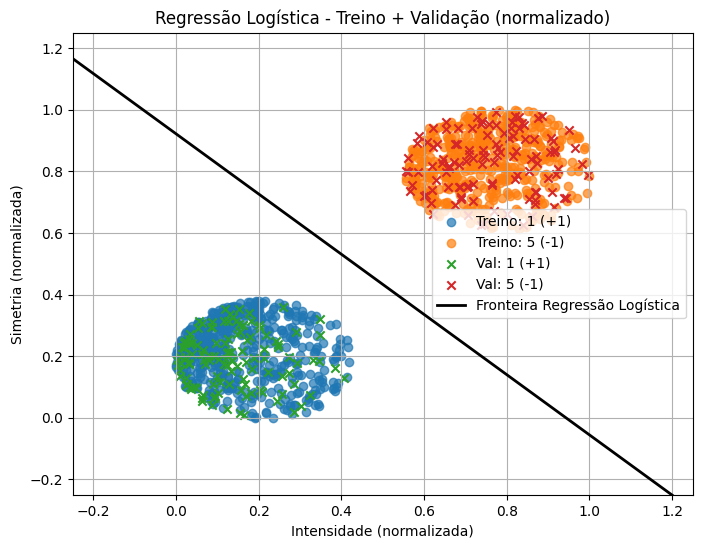

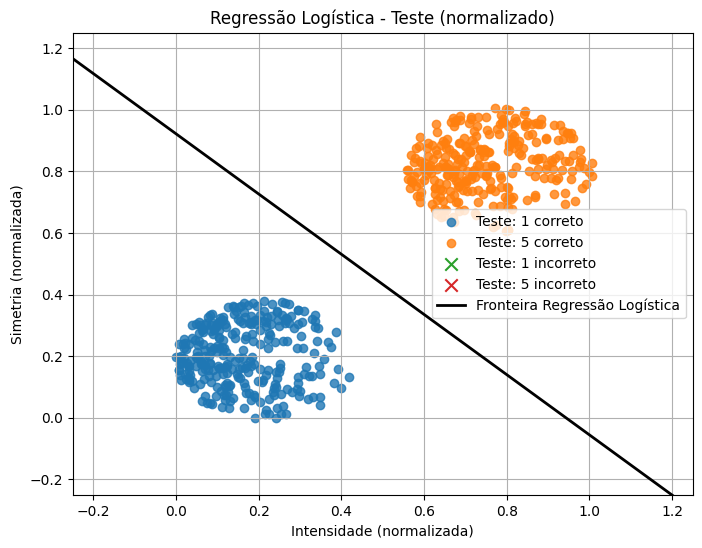

In [ ]:
plot_model_results_normalized(logreg, X_train_1x5, y_train, X_val_1x5, y_val, X_test_1x5, y_test, scaler, "Regressão Logística")

In [ ]:
def plot_all_models_comparison(X_train, y_train, X_val, y_val, X_test, y_test, models, model_names, scale='original', title="Comparação de Modelos Lineares"):
    X_all = np.vstack([X_train, X_val, X_test])
    if scale=='standard':
        scaler = StandardScaler()
        X_train_plot = scaler.fit_transform(X_train)
        X_val_plot   = scaler.transform(X_val)
        X_test_plot  = scaler.transform(X_test)
        X_all_plot   = np.vstack([X_train_plot, X_val_plot, X_test_plot])
    else:
        X_train_plot, X_val_plot, X_test_plot, X_all_plot = X_train, X_val, X_test, X_all

    x_min, x_max = X_all_plot[:,0].min()-0.1, X_all_plot[:,0].max()+0.1
    y_min, y_max = X_all_plot[:,1].min()-0.1, X_all_plot[:,1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Zs = []
    for model in models:
        Z = model.predict(grid)
        Zs.append(Z.reshape(xx.shape))

    colors_models = ['green', 'purple', 'orange']

    y_train_pred = [model.predict(X_train_plot) for model in models]
    y_val_pred   = [model.predict(X_val_plot) for model in models]
    y_test_pred  = [model.predict(X_test_plot) for model in models]

    plt.figure(figsize=(10,7))
    handles = []
    for i, Z in enumerate(Zs):
        plt.contour(xx, yy, Z, colors=colors_models[i], linewidths=2, levels=[0], linestyles='--')
        handles.append(mpatches.Patch(color=colors_models[i], label=f'Fronteira {model_names[i]}'))
    plot_points(np.vstack([X_train_plot, X_val_plot]), np.hstack([y_train, y_val]),
                [np.hstack([y_train_pred[i], y_val_pred[i]]) for i in range(len(models))], label_prefix="Treino+Validação")
    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title(title + " - Treino + Validação")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(handles=handles, fontsize=9, loc='upper right')
    plt.show()

    plt.figure(figsize=(10,7))
    handles = []
    for i, Z in enumerate(Zs):
        plt.contour(xx, yy, Z, colors=colors_models[i], linewidths=2, levels=[0], linestyles='--')
        handles.append(mpatches.Patch(color=colors_models[i], label=f'Fronteira {model_names[i]}'))
    plot_points(X_test_plot, y_test, y_test_pred, label_prefix="Teste")
    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title(title + " - Teste")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(handles=handles, fontsize=9, loc='upper right')
    plt.show()

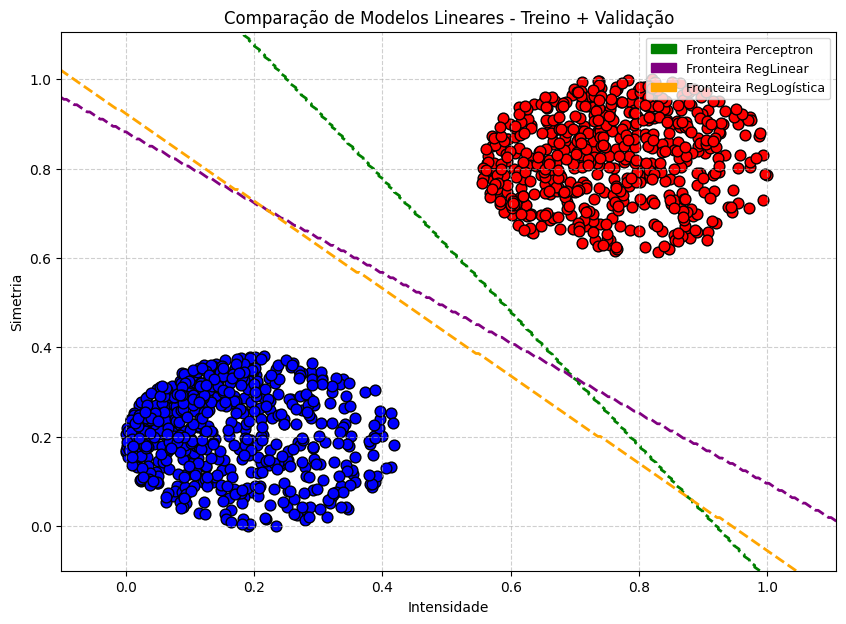

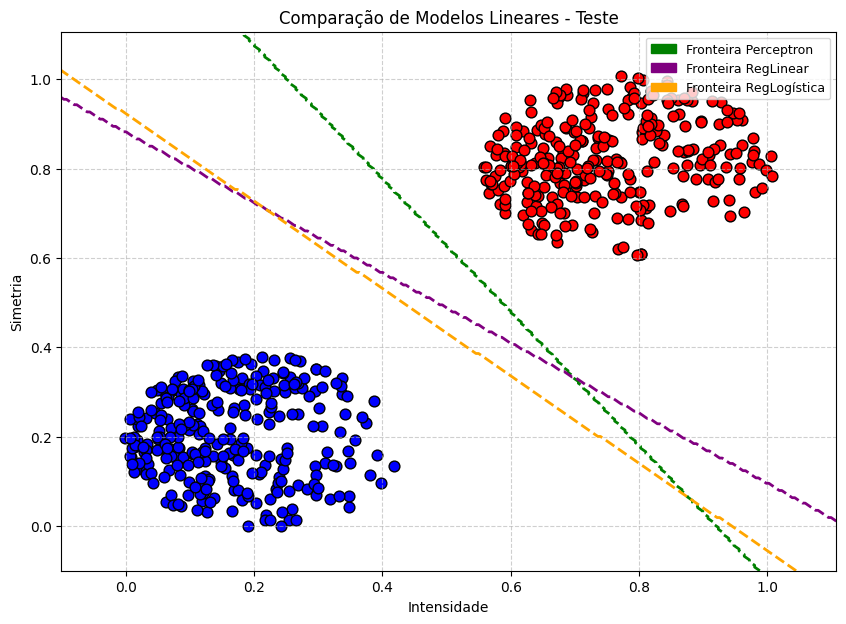

In [ ]:
plot_all_models_comparison(X_train, y_train, X_val, y_val, X_test, y_test,
    models=[perceptron, linreg, logreg],
    model_names=["Perceptron", "RegLinear", "RegLogística"])

## 3. Classificação um contra todos:

In [ ]:
digitos_para_classificar = [0,1,4,5]
treino_filtrado = train_redu[train_redu['label'].isin(digitos_para_classificar)].copy()
teste_filtrado  = test_redu[test_redu['label'].isin(digitos_para_classificar)].copy()

In [ ]:
display(treino_filtrado)
display(teste_filtrado)

,label,intensidade,simetria
0,0,145.435287,148.572556
1,0,118.576469,137.113724
2,0,127.599998,134.047058
3,0,138.047058,151.003922
4,0,146.215683,122.501961
...,...,...,...
2181,5,105.686272,133.890198
2182,5,113.050980,116.698036
2183,5,110.725487,133.019608
2184,5,99.305885,132.133331


,label,intensidade,simetria
0,0,147.933334,130.470581
1,0,131.054901,122.721565
2,0,134.890198,151.725494
3,0,139.976471,133.921570
4,0,129.580399,130.274506
...,...,...,...
1110,5,96.121567,139.521576
1111,5,98.439217,130.729416
1112,5,95.141174,122.227448
1113,5,106.882355,128.007843


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(treino_filtrado[['intensidade','simetria']])
X_test_scaled  = scaler.transform(teste_filtrado[['intensidade','simetria']])

y_train = treino_filtrado['label'].values
y_test  = teste_filtrado['label'].values

In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(2186, 2)
(1115, 2)


In [ ]:
print(X_train_scaled)
print(X_test_scaled)

[[1.8629249  1.560655  ]
 [0.9153894  1.10728   ]
 [1.2337248  0.9859457 ]
 ...
 [0.63841945 0.9452941 ]
 [0.23555441 0.9102281 ]
 [0.3014072  1.2754723 ]]
[[1.951052   0.84444046]
 [1.3556082  0.5378464 ]
 [1.4909112  1.6854029 ]
 ...
 [0.08863015 0.51829636]
 [0.50284    0.7470008 ]
 [0.8823245  0.5639133 ]]


### 3.1 Aplicando um contra todos para todos os modelos de predição:

In [ ]:
def treinar_um_contra_todos(classificador, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4,5]):
    X_train_rest = X_train.copy()
    y_train_rest = y_train.copy()

    classificadores = {}
    scalers = {}

    for digito in digitos_alvo:
        y_bin = np.where(y_train_rest == digito, 1, -1)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_rest)

        clf = classificador()
        clf.fit(X_scaled, y_bin)

        classificadores[digito] = clf
        scalers[digito] = scaler

        pred_train = clf.predict(X_scaled)
        mask_rest = pred_train != 1
        X_train_rest = X_train_rest[mask_rest]
        y_train_rest = y_train_rest[mask_rest]

        if len(X_train_rest) == 0:
            print(f"Todas as amostras foram classificadas antes de treinar o dígito {digito}.")
            break

    previsoes = []
    for x in X_test:
        pred = None
        for digito in digitos_alvo:
            clf = classificadores[digito]
            scaler = scalers[digito]
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        if pred is None:
            pred = 5
        previsoes.append(pred)

    print(f"\nModelo: {classificador.__name__}")
    print(classification_report(y_test, previsoes, digits=2))

    return {digito: (classificadores[digito], scalers[digito]) for digito in classificadores}, previsoes

In [ ]:
def plot_um_contra_todos(classificadores_scalers, X_original, y_original, digitos_alvo=[0,1,4,5]):
    cores_pontos = {0:'purple', 1:'lightgreen', 4:'salmon', 5:'violet'}
    marcadores = {0:'o', 1:'s', 4:'^', 5:'D'}
    cores_linhas = {0:'purple', 1:'lightgreen', 4:'salmon', 5:'violet'}
    estilos_linhas = {0:'--', 1:'-.', 4:':', 5:'-'}

    plt.figure(figsize=(10,8))

    for digito in np.unique(y_original):
        mask = y_original == digito
        plt.scatter(X_original[mask,0], X_original[mask,1],
                    c=cores_pontos.get(digito, 'gray'),
                    marker=marcadores.get(digito, 'o'),
                    edgecolor='k', alpha=0.6,
                    label=f'Dígito {digito}')

    x_min, x_max = X_original[:,0].min() - 0.5, X_original[:,0].max() + 0.5
    y_min, y_max = X_original[:,1].min() - 0.5, X_original[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 350),
                         np.linspace(y_min, y_max, 350))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    for digito in digitos_alvo:
        if digito not in classificadores_scalers:
            continue
        clf, scaler = classificadores_scalers[digito]
        grid_scaled = scaler.transform(grid_points)
        Z = clf.predict(grid_scaled)
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0],
                    colors=cores_linhas.get(digito, 'black'),
                    linestyles=estilos_linhas.get(digito, '--'),
                    linewidths=2,
                    label=f'Fronteira {digito}')

    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title("Fronteiras de decisão - Um Contra Todos")
    plt.grid(alpha=0.3, linestyle=':')
    plt.legend()
    plt.show()

Atenção: número máximo de iterações (10000) atingido. Melhor solução tem 8 erros.
Atenção: número máximo de iterações (10000) atingido. Melhor solução tem 82 erros.
Atenção: número máximo de iterações (10000) atingido. Melhor solução tem 26 erros.

Modelo: PerceptronPLA
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       218
           1       1.00      1.00      1.00       292
           4       0.93      0.98      0.96       314
           5       0.97      0.92      0.94       291

    accuracy                           0.97      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.97      0.97      0.97      1115



/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],


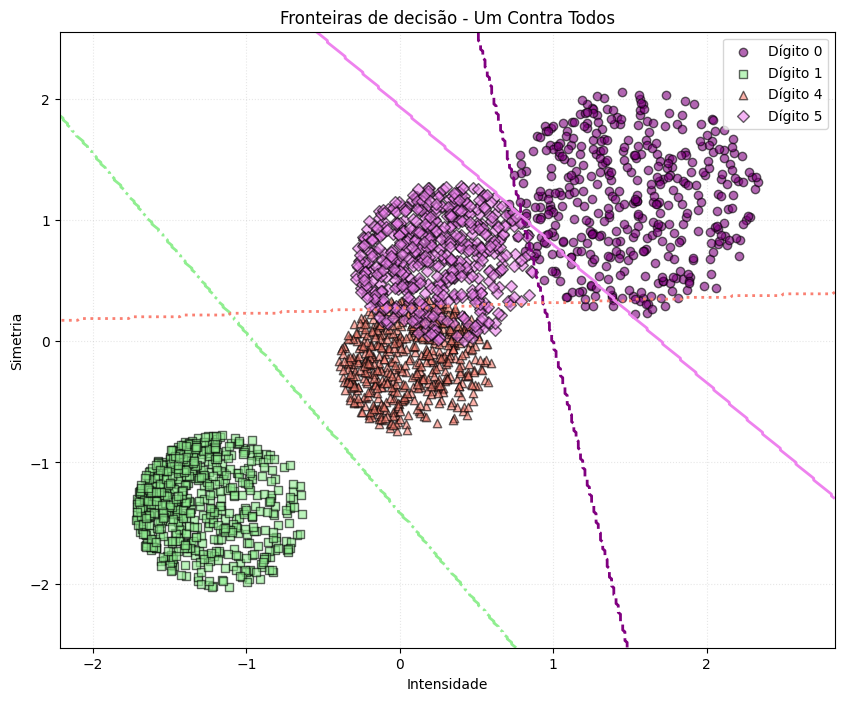

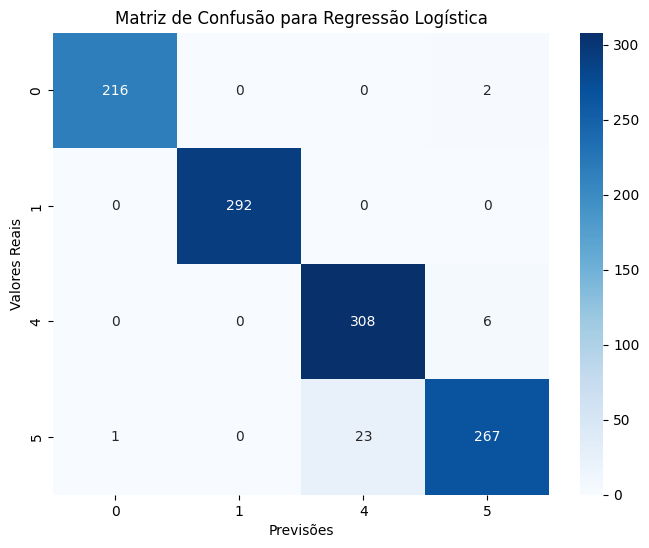

In [ ]:
classificadores_perceptron, previsoes_perceptron = treinar_um_contra_todos(
    PerceptronPLA, X_train_scaled, y_train, X_test_scaled, y_test
)

plot_um_contra_todos(classificadores_perceptron, X_train_scaled, y_train, digitos_para_classificar)

cm = confusion_matrix(y_test, previsoes_perceptron, labels=digitos_para_classificar)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=digitos_para_classificar, yticklabels=digitos_para_classificar)
plt.title('Matriz de Confusão para Regressão Logística')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()


Modelo: RegressaoLinear
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.92      0.99      0.95       314
           5       0.85      0.91      0.88       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],


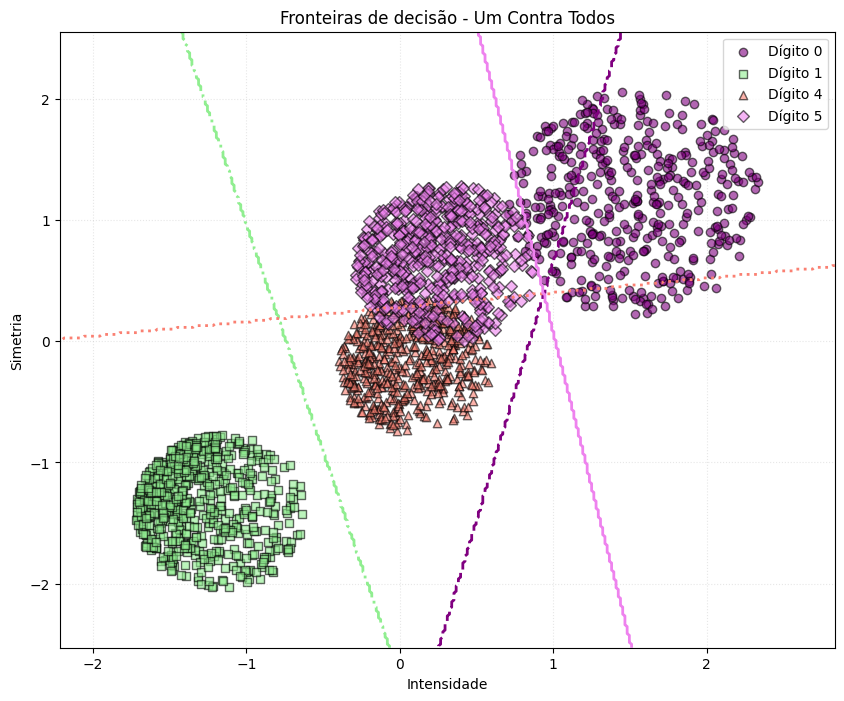

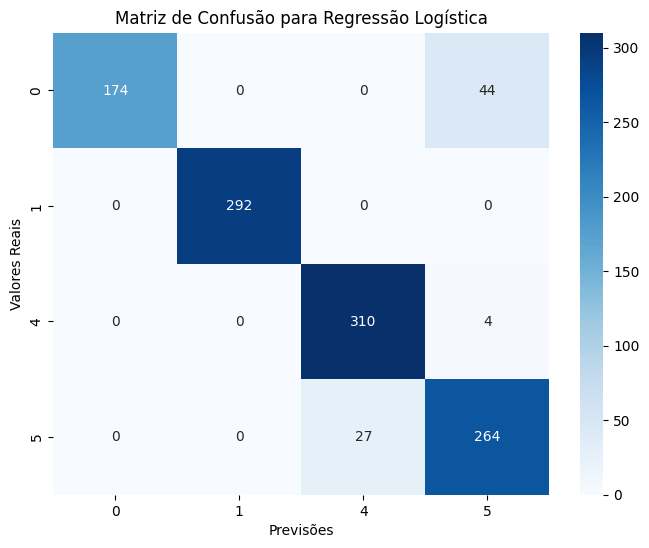

In [ ]:
classificadores_linear, previsoes_linear = treinar_um_contra_todos(
    RegressaoLinear, X_train_scaled, y_train, X_test_scaled, y_test
)

plot_um_contra_todos(classificadores_linear, X_train_scaled, y_train, digitos_para_classificar)

cm = confusion_matrix(y_test, previsoes_linear, labels=digitos_para_classificar)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=digitos_para_classificar, yticklabels=digitos_para_classificar)
plt.title('Matriz de Confusão para Regressão Logística')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()


Modelo: RegressaoLogistica
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       218
           1       1.00      1.00      1.00       292
           4       0.94      0.96      0.95       314
           5       0.92      0.93      0.92       291

    accuracy                           0.96      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],
/tmp/ipython-input-1790088072.py:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0],


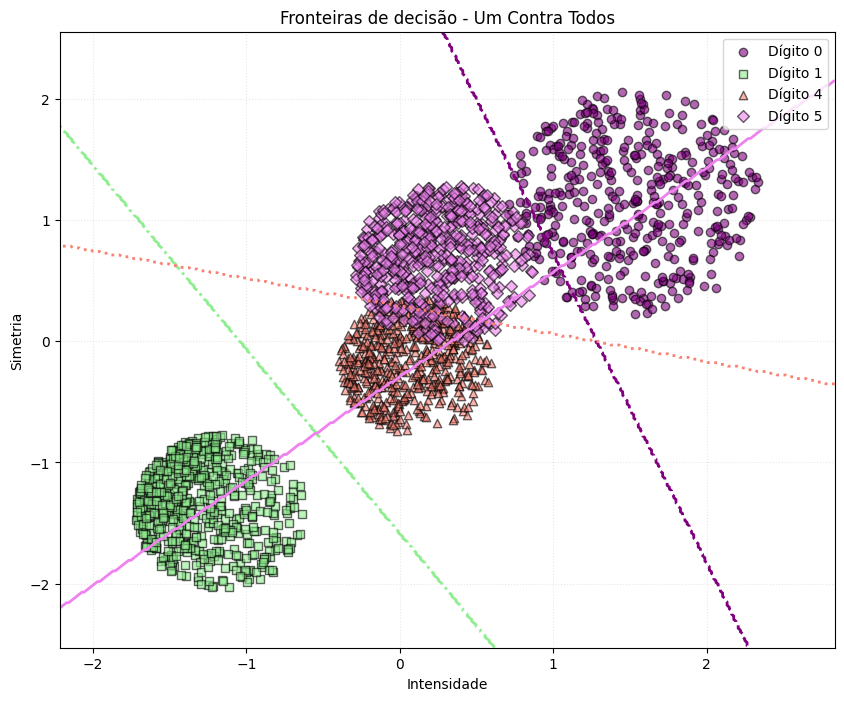

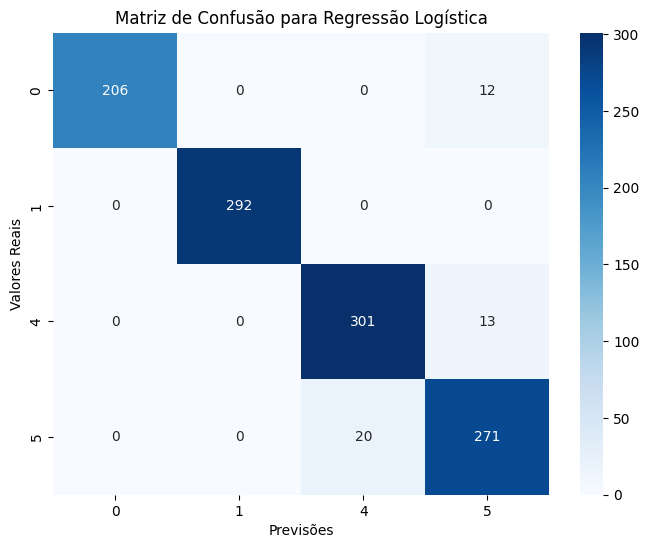

In [ ]:
classificadores_logistica, previsoes_logistica = treinar_um_contra_todos(
    RegressaoLogistica, X_train_scaled, y_train, X_test_scaled, y_test
)

plot_um_contra_todos(classificadores_logistica, X_train_scaled, y_train, digitos_para_classificar)

cm = confusion_matrix(y_test, previsoes_logistica, labels=digitos_para_classificar)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=digitos_para_classificar, yticklabels=digitos_para_classificar)
plt.title('Matriz de Confusão para Regressão Logística')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()